In [ ]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
model = vision_models.InceptionV1()
model.load_graphdef()

from lucid.optvis.objectives import wrap_objective

from PIL import Image

from resizeimage import resizeimage

tf.test.is_gpu_available()

# upload data.csv
# upload style1.png style2.png style3.png
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]
import csv
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("data.csv") 
# Load data 
url_list = list(data['IMAGE LINK'])

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2
content_image = load("style1.png")[..., :3]
style_image = load("style1.png")[..., :3]

def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner

def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix


style_transfer_param(content_image, style_image).shape
import os
os.system("mkdir images")# save the original images
os.system("mkdir helloworld")# save the artificial images
import string
for i in range(10):
  try:
    #download
    url1 = url_list[i]
    #url1 = 'http://museums.bristol.gov.uk/multimedia/entry.php?request=resource&irn=188999&width=1000&format=jpeg'
    download = "wget --output-document hello.jpg '"+url1+"'"
    os.system(download)
    #os.system('wget --output-document auto.jpg {}'.format(url1))
    print(i)
    with open('hello.jpg', 'r+b') as f:
      with Image.open(f) as image:
          cover = resizeimage.resize_cover(image, [300, 290])
          cover.save('images/auto'+str(i)+'.jpg', image.format)
    os.system('rm hello.jpg')
    content_image = load('images/auto'+str(i)+'.jpg')[...,:3]
    style_image = load("style1.png")[..., :3] # choose a style

    print(content_image.shape, style_image.shape)

    show(content_image)
    show(style_image)
    
    # image generate

    param_f = lambda: style_transfer_param(content_image, style_image)
    content_obj = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
    content_obj.description = "Content Loss"

    style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
    style_obj.description = "Style Loss"

    objective = - content_obj - style_obj

    vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]
    show(vis)
    savepath = "helloworld/output" + str(i) + ".jpg"
    save(vis[0], savepath)
  except:
    continue


In [8]:
url1 = url_list[i]
#url1 = 'http://museums.bristol.gov.uk/multimedia/entry.php?request=resource&irn=188999&width=1000&format=jpeg'
download = "wget --output-document hello.jpg '"+url1+"'"
os.system(download)
#os.system('wget --output-document auto.jpg {}'.format(url1))
print(i)
with open('hello.jpg', 'r+b') as f:
  with Image.open(f) as image:
      cover = resizeimage.resize_cover(image, [200, 190])
      cover.save('images/auto'+str(i)+'.jpg', image.format)
os.system('rm hello.jpg')
content_image = load('images/auto'+str(i)+'.jpg')[...,:3]
style_image = load("style1.png")[..., :3] # choose a style

print(content_image.shape, style_image.shape)


9
(190, 200, 3) (290, 300, 3)



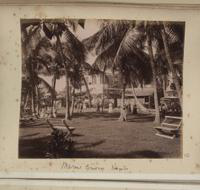


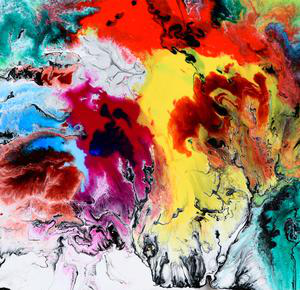


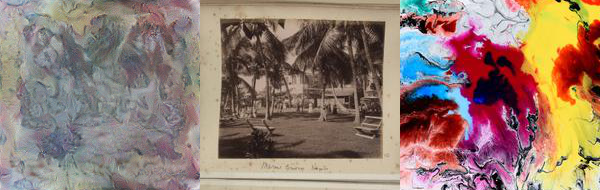

IndexError: list index out of range

In [9]:

show(content_image)
show(style_image)

# image generate


In [17]:

param_f = lambda: style_transfer_param(content_image, style_image)
content_obj = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[100], verbose=False, print_objectives=[content_obj, style_obj])[-1]



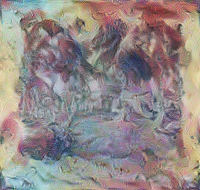
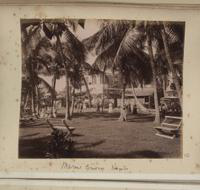
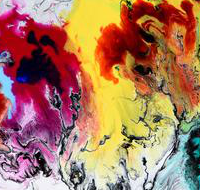

In [18]:
show(vis)

In [ ]:
savepath = "helloworld/output" + str(i) + ".jpg"
save(vis[0], savepath)